<a href="https://colab.research.google.com/github/MatCat960/gmm_coverage/blob/master/roadsGMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import time, cv2
import tensorflow as tf
from tkinter import filedialog
import numpy as np
from sklearn.mixture import GaussianMixture
# from smooth_predictions_by_belnding_patches import predict_img_with_smooth_windowing
# from patchify import patchify, unpatchify
from matplotlib import pyplot as plt
from matplotlib import cm
from google.colab import files

In [ ]:
!pip install patchify
from patchify import patchify, unpatchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount("mnt")

Mounted at mnt


In [ ]:
%cd "/content/mnt/MyDrive/Colab Notebooks/road_extraction_GMM"

!pip install import-ipynb
import import_ipynb

from smoothPrediction import predict_img_with_smooth_windowing

/content/mnt/MyDrive/Colab Notebooks/road_extraction_GMM
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.3 MB/s eta 0:00:00
importing Jupyter notebook from smoothPrediction.ipynb


In [ ]:
my_dpi = 96
DIM_MT_IMG = [300, 200]
COMPONENTS_NUM = 20

In [ ]:
def recompone_images(pat, x, y):
    row = []
    backtoimg = []
    for i in range(len(pat)):
        row.append(np.array(pat[i]))
        if (i+1) % x == 0:
            backtoimg.append(row)
            row = []
    backtoimg = np.array(backtoimg)
    img = unpatchify(backtoimg, (y*256, x*256))
    return img

In [ ]:
def predict(name):
    image = cv2.imread(name, cv2.COLOR_BGR2RGB)

    nr1 = int(image.shape[0] / 256.)
    nc1 = int(image.shape[1] / 256.)
    image = image[0:nr1*256, 0:nc1*256]

    if nr1 > nc1:
        n = int( nr1/nc1 )
        image1 = cv2.resize(image, (256,256*n))
    else:
        n = int( nc1/nr1 )
        image1 = cv2.resize(image, (256*n,256))

    nr = int(image1.shape[0] / 256.)
    nc = int(image1.shape[1] / 256.)

    model = tf.keras.models.load_model("RoadExtractionModel.h5", compile=False)
    #model = tf.keras.models.load_model(r"C:\Users\albon\Downloads\RoadDetectionModel-0.615.h5", compile=False)
    #model = tf.keras.models.load_model(r"C:\Users\albon\Downloads\mB-210-0.64-0.58.h5", compile=False)

    patch_size = 256
    patches = []

    patches_img = patchify(image1, (patch_size, patch_size, 3), step=patch_size)
    for k in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[k,j,:,:]
            single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds
            patches.append(single_patch_img)

    #Prediction without using blending patches
    mask_patches = []
    for i in range(len(patches)):
        img = patches[i] / 255.0
        p0 = model.predict(np.expand_dims(img, axis=0))[0][:, :, 0]
        p1 = model.predict(np.expand_dims(np.fliplr(img), axis=0))[0][:, :, 0]
        p1 = np.fliplr(p1)
        p2 = model.predict(np.expand_dims(np.flipud(img), axis=0))[0][:, :, 0]
        p2 = np.flipud(p2)
        p3 = model.predict(np.expand_dims(np.fliplr(np.flipud(img)), axis=0))[0][:, :, 0]
        p3 = np.fliplr(np.flipud(p3))
        thresh = 0.2
        p = (p0 + p1 + p2 + p3) / 4
        mask_patches.append(p)

    prediction = recompone_images(mask_patches, nc, nr)
    pred = (prediction > thresh).astype(np.uint8)

    #Prediction using blending patches
    input_img = image1/255.
    predictions_smooth = predict_img_with_smooth_windowing(
                                                        input_img,
                                                        window_size=patch_size,
                                                        subdivisions=2,
                                                        nb_classes=1,
                                                        pred_func=(lambda img_batch_subdiv: model.predict((img_batch_subdiv)))
                                                        )

    final_prediction = (predictions_smooth > thresh).astype(np.uint8)
    union_prediction = (((prediction + 2*predictions_smooth[:,:,0]) / 2) > thresh).astype(np.uint8)
    return union_prediction*255

In [ ]:
def distmt(x, y, img_size, mt):
    dist_x = (x*mt[0])/img_size[1]
    dist_y = (y*mt[1])/img_size[0]
    return [math.sqrt(dist_x**2+dist_y**2), dist_x, dist_y]

In [ ]:
# X, Y : meshgrid
def multigauss_pdf(X, Y, means, covariances, weights):
  # Flatten the meshgrid coordinates
    points = np.column_stack([X.flatten(), Y.flatten()])

    # Number of components in the mixture model
    num_components = len(means)

    # Initialize the probabilities
    probabilities = np.zeros_like(X)

    # Calculate the probability for each component
    for i in range(num_components):
        mean = means[i]
        covariance = covariances[i]
        weight = weights[i]

        # Calculate the multivariate Gaussian probability
        exponent = -0.5 * np.sum((points - mean) @ np.linalg.inv(covariance) * (points - mean), axis=1)
        coefficient = 1 / np.sqrt((2 * np.pi) ** 2 * np.linalg.det(covariance))
        component_prob = coefficient * np.exp(exponent)

        # Add the component probability weighted by its weight
        probabilities += weight * component_prob.reshape(X.shape)

    return probabilities

1/1 [==============================] - 1s 704ms/step


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


 12%|█▎        | 1/8 [00:11<01:23, 11.91s/it]

1/1 [==============================] - 6s 6s/step


 25%|██▌       | 2/8 [00:23<01:11, 11.93s/it]

1/1 [==============================] - 6s 6s/step


 38%|███▊      | 3/8 [00:31<00:49,  9.95s/it]

1/1 [==============================] - 7s 7s/step


 50%|█████     | 4/8 [00:40<00:38,  9.71s/it]

1/1 [==============================] - 7s 7s/step


 62%|██████▎   | 5/8 [00:52<00:31, 10.53s/it]

1/1 [==============================] - 6s 6s/step


 75%|███████▌  | 6/8 [01:00<00:19,  9.63s/it]

1/1 [==============================] - 7s 7s/step


 88%|████████▊ | 7/8 [01:12<00:10, 10.48s/it]

1/1 [==============================] - 8s 8s/step


100%|██████████| 8/8 [01:22<00:00, 10.33s/it]


(256, 256)
Means: [[182.54640134  24.19530529]
 [101.73860768  70.0394101 ]
 [175.81644367 133.28022593]
 [280.21448944  98.75338978]
 [117.15997683 185.65043449]
 [219.6194107   25.49376686]
 [ 44.1814962  184.96754296]
 [ 68.1230677   22.92797615]
 [194.41443378 116.60600774]
 [ 98.41345284 161.87066081]
 [132.21502258  48.91340668]
 [ 85.64421284 104.95568818]
 [ 43.5666739   86.44289141]
 [182.84508781  76.73232607]
 [ 98.45251837 139.29247278]
 [273.4536616   63.63503648]
 [ 60.74196546  43.82691234]
 [232.74916399 114.69458316]
 [278.75803869   7.93917188]
 [147.29098122 152.35971291]]
Coveriances: [[[  21.70250974  -36.79467338]
  [ -36.79467338  210.58863284]]

 [[ 142.62945337  -80.25651377]
  [ -80.25651377   60.4318353 ]]

 [[ 107.40205135  -43.03473946]
  [ -43.03473946  135.17114575]]

 [[ 146.24898632  -43.46981748]
  [ -43.46981748   24.92396562]]

 [[  46.94126671  -60.79163161]
  [ -60.79163161  101.62321001]]

 [[1035.70227124 -297.68660722]
  [-297.68660722   90.0636

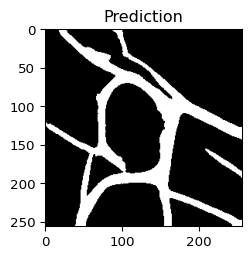

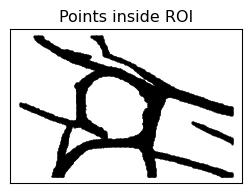

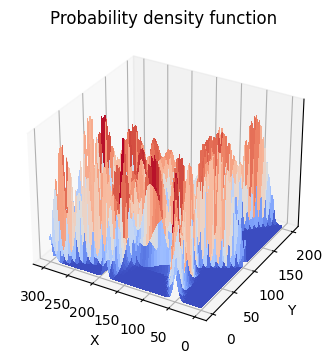

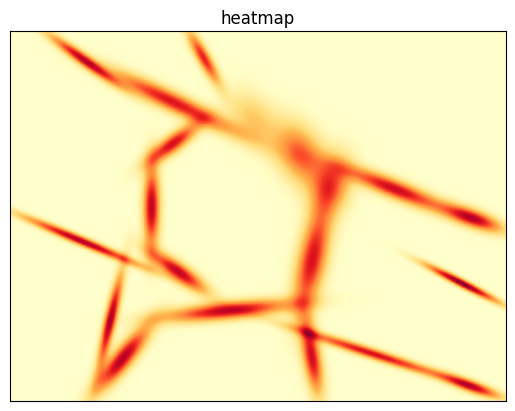

In [ ]:
xp, yp = [], []
path = "/content/mnt/MyDrive/Colab Notebooks/road_extraction_GMM"
file_types = [('Image', '*.jpg;*.png'), ('All files', '*')]
# name = filedialog.askopenfilename(title='Select an image:', filetypes=file_types, initialdir=path)
name = "/content/mnt/MyDrive/Colab Notebooks/road_extraction_GMM/colosseo.PNG"
image = predict(name)
IMG_SIZE = image.shape
print(IMG_SIZE)
plt.figure(figsize=(IMG_SIZE[0]/my_dpi, IMG_SIZE[1]/my_dpi), dpi=my_dpi)
plt.title("Prediction")
plt.imshow(image, cmap='gray')

for i in range(IMG_SIZE[0]):
    for j in range(IMG_SIZE[1]):
        if image[i,j] == 255:
            #xp.append(j)
            #yp.append(IMG_SIZE[1]-i)
            k,x,y = distmt(j, i, IMG_SIZE, DIM_MT_IMG)
            xp.append(x)
            yp.append(DIM_MT_IMG[1]-y)

#plt.show()

GMModel = GaussianMixture(n_components=COMPONENTS_NUM, covariance_type='full', max_iter=1000)
GMModel.fit(np.column_stack((xp, yp)))
# calculate BIC
# bic = GMModel.bic(np.column_stack((xp, yp)))

# get means and covariances
means = GMModel.means_
covariances = GMModel.covariances_
mix = GMModel.weights_
print("Means: {}".format(means))
print("Coveriances: {}".format(covariances))
print("Mixture proportions: {}".format(mix))

# generate grid
# xgrid = np.linspace(0,image.shape[0])
# ygrid = np.linspace(0,image.shape[1])
# X, Y = np.meshgrid(xgrid, ygrid)
    #plt.figure(figsize=(IMG_SIZE[0]/my_dpi, IMG_SIZE[1]/my_dpi), dpi=my_dpi)
plt.figure(figsize=(DIM_MT_IMG[0]/my_dpi, DIM_MT_IMG[1]/my_dpi), dpi=my_dpi)
plt.scatter(xp[:], yp[:], marker='.', color='k', s=1)
plt.title("Points inside ROI")
plt.xticks([])
plt.yticks([])
# plt.savefig("points.png")
# files.download("points.png")
#plt.show()

# plot distribution
    #X = np.arange(0, IMG_SIZE[0], 0.1)
    #Y = np.arange(0, IMG_SIZE[1], 0.1)
X = np.arange(0, DIM_MT_IMG[0], 0.1)
Y = np.arange(0, DIM_MT_IMG[1], 0.1)
X, Y = np.meshgrid(X, Y)
Z = multigauss_pdf(X, Y, means, covariances, mix)

fig, ax = plt.subplots(1, 1, figsize=(12,4), subplot_kw={"projection": "3d"})

#3D surface plot
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel("X"); ax.set_ylabel("Y")
ax.set_zticks([])
ax.set_title("Probability density function")
ax.invert_xaxis()
# ax.view_init(60,60,0)

# 2D heatmap
fig2, ax2 = plt.subplots(1, 1)

z_min = np.min(Z); z_max = np.max(Z)
c = ax2.pcolormesh(X, Y, Z, cmap='YlOrRd', vmin=z_min, vmax=z_max)
ax2.set_title("heatmap")
# fig2.colorbar(c, ax=ax2)
    #ax2.set_xlim([0, IMG_SIZE[0]]); ax2.set_ylabel([0, IMG_SIZE[1]])
ax2.set_xlim([0, DIM_MT_IMG[0]]); ax2.set_ylim([0, DIM_MT_IMG[1]])
plt.xticks([]); plt.yticks([])
# plt.savefig("heatmap.png")
# files.download("heatmap.png")
plt.show()